# Projecte github

# Imports

In [357]:
# Draw the plots immediately after the current cell
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
plt.style.use('default')

import pandas as pd
import numpy as np
# Uncomment the following line to install pymysql
#!pip install PyMySQL
import pymysql
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# POLARS # <- teacher said that this one is 1000% faster than pandas.

# Project configuration

The file that we are going to use to set up the basic structure:

GitHubScraper/JupyterNotebook/Structure/githubProjectStructure.sql

from the github repository.

### Step 1, import the structure
In workbench: 
"Server" -> "Data Import", and then you should select the direction of "githubProjectStructure.sql" using the 3 dots and import from self-contained file like in the following image:

![Javatpoint](./Images/Project_Setup/data_import.png)  

Then scroll down, and create a new Schema by clicking on the "New..." button. Name it: "githubProject".

![Javatpoint](./Images/Project_Setup/create_new_schema.png)  

Scroll to the bottom, and in the bottom right, click on "Start import". If there are no errors, it will transitionate to "Import progress" and indicate success.

Refresh the scehmas:

![Javatpoint](./Images/Project_Setup/refresh.png)  

### Step 2, importing the data from the csv files

Download the csv files [here](https://drive.google.com/drive/folders/1NWhfFss0_M9V_clkcE9TH-Fy3oIEndWV?usp=sharing).

Selecting the "githubProject" scheme, right click and "Table Data Import Wizard", with this, we are going to import each csv file to the matching table.

You have to select the .csv you want to import, for example in this case, the trendVisits.csv

![Javatpoint](./Images/Project_Setup/file_import.png) 

Then, since you already have the structure, you have to use the existing table that matches with the correct csv file:

![Javatpoint](./Images/Project_Setup/use_existing.png) 

After that, check that the variables type are correct and import it. Do this for each csv file.

You can also verify the data by doing this:

![Javatpoint](./Images/Project_Setup/verify.png) 



# Introduction

TODO index or sections indicating what are we doing...

In [358]:
#https://www.geeksforgeeks.org/connect-to-mysql-using-pymysql-in-python/
# Connect to MySQL database
def tryToConnectMySQL(db_name, db_host, db_port, db_username, db_password):
    try:
        conn = pymysql.connect(host=db_host,
                               port=db_port,
                               user=db_username,
                               password=db_password,
                               db=db_name)
        if conn:
            print("Connection successful")
        else:
            print("Error")
        
        return conn
        
    except pymysql.Error as e:        
        warnings.warn("Error connecting to MySQL:", e)
        return None

# Pass arguments from outside
db_name = "githubProject"
db_host = "localhost"
db_port = 3306
db_username = "root"
db_password = input("Input your password")

dataBaseConnection = tryToConnectMySQL(db_name, db_host, db_port, db_username, db_password)

TypeError: category must be a Warning subclass, not 'OperationalError'

In [ ]:
# Execute query and return data in pandas dataframe 
def execute_select_query(cursor, query):
    try:
        cursor.execute(query)
        output = cursor.fetchall()
        # Fetch column names from cursor's description
        columns = [desc[0] for desc in cursor.description]
        
        # Convert output to pandas DataFrame
        if output:
            df = pd.DataFrame(output, columns=columns)
            print("Query executed successfully!")
        return output, df
            
    except pymysql.Error as e:
        print("Error executing query:")
        warnings.warn(str(e))
        return None, None

In [ ]:
# Obtain the cursos in order to interact with the DataBase
cursor = dataBaseConnection.cursor()

# Tables
Shows the table for the different entities of the Data Base.

## Repositories

In [ ]:
query = "SELECT * FROM Repositories WHERE mainLanguage != \"\""
print(query)
output_repo, df_repo = execute_select_query(cursor, query)
df_repo.tail(5)

SELECT * FROM Repositories WHERE mainLanguage != ""
Query executed successfully!


,owner,name,description,mainLanguage,license
2037,syncany,syncany-plugin-flickr,Syncany Flickr Plugin (fun plugin),Java,GPL-3.0 license
2038,syncany,syncany-plugin-gui,Syncany GUI Plugin,Java,GPL-3.0 license
2039,syncany,syncany-plugin-dropbox,Dropbox plugin for Syncany,Java,GPL-3.0 license
2040,syncany,syncany-plugin-simpleweb,Syncany Simple Web Interface plugin (outdated ...,Java,GPL-3.0 license
2041,syncany,syncany-plugin-webdav,Syncany WebDAV plugin,Java,GPL-3.0 license


In [ ]:
query = "SELECT * FROM RepositoryVisits;"

output_repo_visists, df_repo_visists = execute_select_query(cursor, query)
df_repo_visists.head(5)

Query executed successfully!


,date,owner,name,forks,commits,stars,watchers,contributors,openIssues,closedIssues,openPullRequests,closedPullRequests
0,2024-03-03 09:29:47,go-gitea,gitea,5100,17384,-1,-1,-1,-1,-1,-1,-1
1,2024-03-03 09:29:48,colbyfayock,next-wordpress-starter,279,772,-1,-1,-1,-1,-1,-1,-1
2,2024-03-03 09:29:50,mattermost,mattermost,6700,18212,-1,-1,-1,-1,-1,-1,-1
3,2024-03-03 09:29:51,Luohuayu,CatServer,194,-1,-1,-1,-1,-1,-1,-1,-1
4,2024-03-03 09:29:57,hoppscotch,hoppscotch,4100,5164,-1,-1,-1,-1,-1,-1,-1


In [ ]:
query = "SELECT * FROM RepositoryTopics;"

output_repo_topics, df_repo_topics = execute_select_query(cursor, query)
df_repo_topics.head(5)

Query executed successfully!


,owner,repo,topic
0,PinewoodPip,EpipEncounters,mod
1,PinewoodPip,EpipEncounters,divinity
2,PinewoodPip,EpipEncounters,divinity-original-sin-2
3,go-gitea,gitea,github
4,go-gitea,gitea,git


## Owners

In [ ]:
query = "SELECT * FROM Owners;"
# Use _ to ignore
_, df_owners = execute_select_query(cursor, query)
df_owners.head(5)

Query executed successfully!


,username,avatar_url
0,PinewoodPip,https://avatars.githubusercontent.com/u/536469...
1,go-gitea,https://avatars.githubusercontent.com/u/127243...
2,colbyfayock,https://avatars.githubusercontent.com/u/104527...
3,mattermost,https://avatars.githubusercontent.com/u/497571...
4,Luohuayu,https://avatars.githubusercontent.com/u/290957...


In [ ]:
query = "SELECT * FROM OwnerVisits;"

output_owner_visits, df_owner_visits = execute_select_query(cursor, query)
df_owner_visits.head(5)

Query executed successfully!


,date,username,contributionsLastYear
0,2024-03-03 09:29:46,PinewoodPip,1774
1,2024-03-03 09:29:49,colbyfayock,1878
2,2024-03-03 09:29:56,Luohuayu,79
3,2024-03-03 09:30:03,jacopotediosi,376
4,2024-03-03 09:30:06,trekhleb,210


## Commits

In [ ]:
query = "SELECT * FROM Commits;"

output_commits, df_commits = execute_select_query(cursor, query)
df_commits.head(5)

Query executed successfully!


,sha,author,repository,repositoryOwner,message
0,ea745d855eea318402d9ae9c9266c3657b1b96b4,PinewoodPip,ee2buildplanner,PinewoodPip,Add search bar functionality to aspect picker
1,00f8e2373d1a56681c8d67edca2b0bd6d0f2ee66,PinewoodPip,ee2buildplanner,PinewoodPip,Additional fixes to skill descriptions
2,9fd29f087f07bd6fe8b8c977df6de8490d768a92,PinewoodPip,ee2buildplanner,PinewoodPip,Add Dominatrix build and declare the app v1.0
3,6e0428cc190dd0d7fb7d33425fc1332b79096cf6,PinewoodPip,ee2buildplanner,PinewoodPip,Add armor runes and bump ver to 0.9.1
4,16d69f8f4639ffc265634c2e0b6e9d27c8d75c1e,PinewoodPip,ee2buildplanner,PinewoodPip,Update README.md


## Topics

In [ ]:
query = "SELECT * FROM Topics;"

output_topics, df_topics = execute_select_query(cursor, query)
df_topics.tail(5)

Query executed successfully!


,name,mainLanguage
4945,formdata,
4946,xhr2-fd,
4947,kubeflow,
4948,kubeflow-community,
4949,decompilation,


In [ ]:
query = "SELECT CAST(date AS Date) AS date, name, repositories, followers FROM TopicVisits;"

_, df_topic_visits = execute_select_query(cursor, query)
df_topic_visits.head(5)

Query executed successfully!


,date,name,repositories,followers
0,2024-03-04,nodejs,238297,77600
1,2024-03-04,javascript,510373,169000
2,2024-03-04,npm,19224,28800
3,2024-03-04,next,4376,1500
4,2024-03-04,react,347483,98800


## Trend

In [ ]:
query = "SELECT * FROM TrendVisits;"

_, df_trend_visits = execute_select_query(cursor, query)
df_trend_visits.head(5)

Query executed successfully!


,date,repo_name,owner,starsToday
0,2024-04-10 09:27:40,plandex-ai,plandex,1459
1,2024-04-10 09:27:40,nashsu,FreeAskInternet,1284
2,2024-04-10 09:27:40,drawdb-io,drawdb,665
3,2024-04-10 09:27:40,langgenius,dify,581
4,2024-04-10 09:27:40,PawanOsman,ChatGPT,410


# Analysis planning

### Basic statistics
* Distribution of main topics (bar or pie chart). Aka, in what proportion of our studied repos are they treated.
* Distribution of languages (bar or pie chart). Like above.
* Time evolution of interest in topics: repositories per topic, followers per topic.

### Dimensional reduction for an overview on repositories
What we mean here is to perform a PCA (principal components analysis) in order to able to have an insight on the structre of the whole dataset. We would then color the data points in it depending on the language used, for instance, to see if these groups have similar characteristics and lie close in the dataframe or not.
* Create a dataframe containing all RepositoryVisits data for a certain date for all the studied repositories.
* Perform a standarization on the data (i.e., to prevent some variables such as commits to be far more important than others such as forks).
* Perform a PCA into 2 components on it.
* Plot the results while clustering the points depending on different criteria:
    + mainLanguage
    + topic

### Open questions
* How to use stars and trends?
* How to use contributions by owners?


## Distributions

In [ ]:
# Define cut number
n = 20

Main topics present in 14.49% of repositories.
(4950, 1)


,count
topic,
hacktoberfest,216
javascript,200
react,180
typescript,139
nodejs,110
...,...
switch,1
gamecube,1
wii,1


['hacktoberfest', 'javascript', 'react', 'typescript', 'nodejs', 'python', 'docker', 'nextjs', 'golang', 'go', 'git', 'minecraft', 'java', 'vue', 'machine-learning', 'android', 'deep-learning', 'github', 'ios', 'cli']


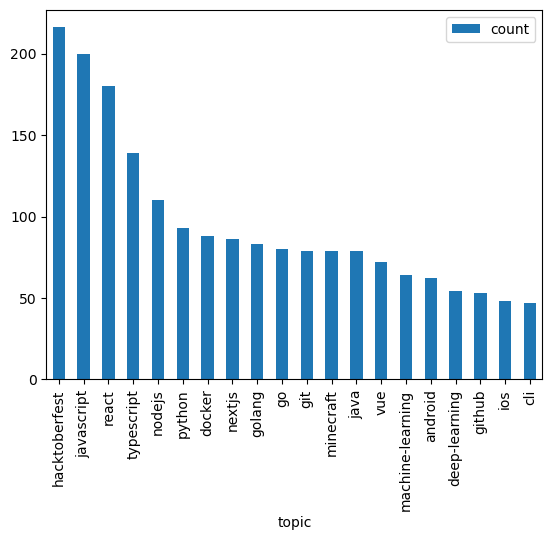

In [ ]:
topics = df_repo_topics["topic"].value_counts().to_frame()
topics_count = topics.sum()
n_topics_count = topics[:n].sum()
n_topics_name = df_repo_topics["topic"].value_counts()[:n].index.to_list()
print("Main topics present in {:.2f}% of repositories.".format(float((n_topics_count / topics_count).iloc[0]) * 100))
print(topics.shape)
display(topics)
topics[:n].plot.bar()
print(n_topics_name)

In the previous bar chart it is showed the first 20 most frequent topics treated in our repositories. However, they are only present in 15% of them, which shows us that our sample is widely distributed.

,count
mainLanguage,
TypeScript,368
JavaScript,309
Python,218
Go,160
Java,158
...,...
Roff,1
Smalltalk,1
PureScript,1


Main topics present in 93.05% of repositories.
(78, 1)


,count
mainLanguage,
TypeScript,368
JavaScript,309
Python,218
Go,160
Java,158
...,...
Roff,1
Smalltalk,1
PureScript,1


<Axes: xlabel='mainLanguage'>

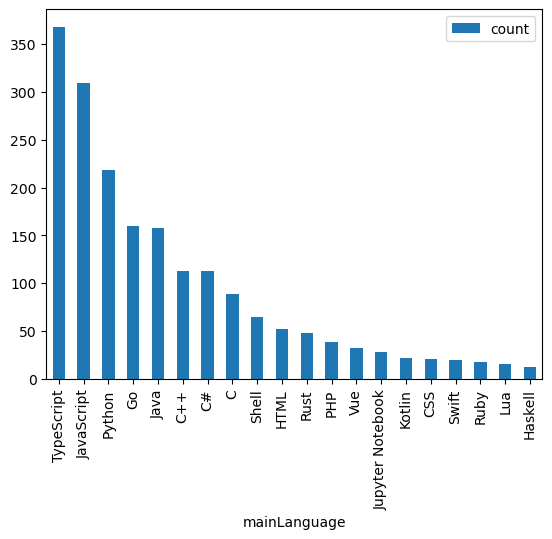

In [ ]:
# Remove duplicates
tmp = df_repo.drop(df_repo[df_repo["mainLanguage"] == ""].index)
languages = tmp["mainLanguage"].value_counts().to_frame()
display(languages)
languages_count = languages.sum()
n_languages_count = languages[:n].sum()
print("Main topics present in {:.2f}% of repositories.".format(float((n_languages_count / languages_count).iloc[0]) * 100))
print(languages.shape)
display(languages)
languages[:n].plot.bar()

The most used languages our repositories sample are languages oriented to web developing. Followed by Python, Go, Java and C++. These top used languages account for over 90% of the repositories.

In [ ]:
df_topic_visits_n_cut = df_topic_visits[df_topic_visits["name"].isin(n_topics_name)]
df_topicv_repos = df_topic_visits_n_cut[["date", "name", "repositories"]]
n_topics_name
display(df_topic_visits_n_cut)

,date,name,repositories,followers
0,2024-03-04,nodejs,238297,77600
1,2024-03-04,javascript,510373,169000
4,2024-03-04,react,347483,98800
5,2024-03-04,nextjs,81661,1500
8,2024-03-04,vue,54146,59000
...,...,...,...,...
556,2024-05-12,react,356153,99800
557,2024-05-12,nextjs,86301,1600
560,2024-05-12,vue,54744,59300
563,2024-05-12,machine-learning,125070,76600


<Axes: xlabel='date'>

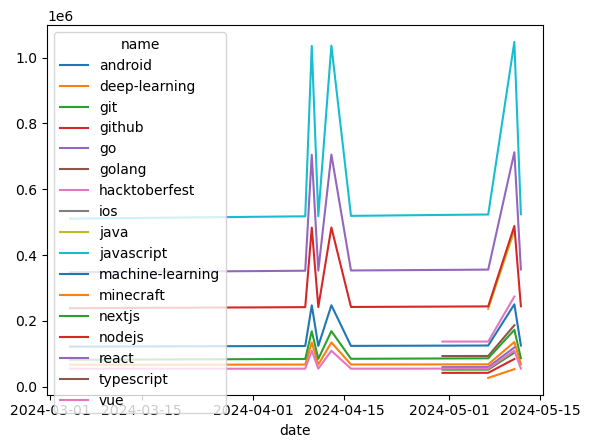

In [ ]:
df_topicv_repos.pivot_table(index='date', columns="name", values="repositories", aggfunc="sum").plot()

O he fet algo fatal o vam actualitzar les dades només aquests tres dies i, per tant, no hi surt res interessant

Volem ara veure una evolució de la popularitat dels repositoris tractant els temes que hem identificat com a principals. És a dir, volem veure com ha anat canviant el nombre d'estrelles que reben aquests repositoris. Aquesta és una bona oportunitat que tenim per a treballar els joins entre taules.

In [ ]:
query = """WITH RepositoriesMainTopics AS (
	SELECT repo AS name, topic
    FROM RepositoryTopics
    WHERE topic IN ('hacktoberfest', 'javascript', 'react', 'typescript', 'nodejs', 'python', 'docker', 'nextjs', 'golang', 'go', 'git', 'minecraft', 'java', 'vue', 'machine-learning', 'android', 'deep-learning', 'github', 'ios', 'cli')
), TrendingTopic AS (
	SELECT date, repo_name AS name, topic,  starsToday as stars
    FROM RepositoriesMainTopics
    JOIN TrendVisits ON TrendVisits.repo_name = RepositoriesMainTopics.name
)
SELECT CAST(date AS Date) AS date, topic, SUM(stars) AS stars
FROM TrendingTopic
GROUP BY date, topic"""
"SELECT * FROM TrendVisits;"
_, df_trendRepositoriesMainTopics = execute_select_query(cursor, query)
df_trendRepositoriesMainTopics.head(5)

Query executed successfully!


,date,topic,stars
0,2024-04-10,cli,14
1,2024-04-10,machine-learning,31
2,2024-04-10,android,24
3,2024-04-10,hacktoberfest,24
4,2024-04-10,docker,8


In [ ]:
df_trendRepositoriesMainTopics["stars"] = df_trendRepositoriesMainTopics["stars"].astype(float)
df_trendRepositoriesMainTopics.dtypes

date      object
topic     object
stars    float64
dtype: object

<Axes: xlabel='date'>

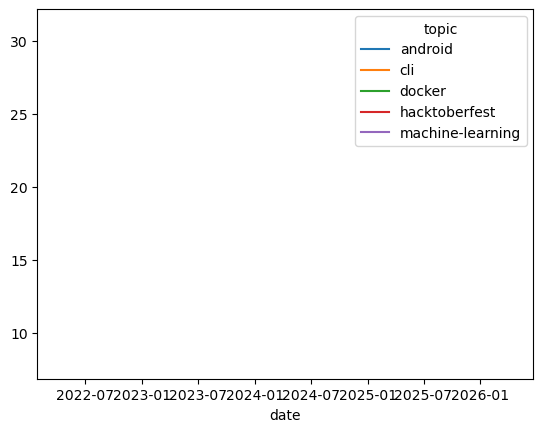

In [ ]:
df_trendRepositoriesMainTopics.pivot_table(index='date', columns="topic", values="stars", aggfunc="sum").plot()

I de moment aquest gràfic no aporta res perquè les dades del moment van ser totes extretes el mateix dia.

## Overall structure of the repositories numerical data

In [383]:
query = """SELECT CONCAT(RepositoryVisits.owner,RepositoryVisits.name) AS id, forks, commits, stars, watchers, contributors, openIssues, closedIssues, mainLanguage
FROM RepositoryVisits
JOIN Repositories ON RepositoryVisits.owner = Repositories.owner AND RepositoryVisits.name = Repositories.name
WHERE CAST(date AS Date) = '2024-04-16'
"""

_, df = execute_select_query(cursor, query)
df.head(5)


Query executed successfully!


,id,forks,commits,stars,watchers,contributors,openIssues,closedIssues,mainLanguage
0,Gegel85SokuAI,1,63,9,3,2,0,0,C++
1,SokuDevSokuLib,5,134,5,3,5,1,2,C
2,SokuDevSokuMods,10,583,38,3,4,6,10,C++
3,Gegel85SoFGV,1,505,5,1,2,0,0,C++
4,Gegel85GBEmulator,0,485,0,2,4,0,6,C++


In [384]:
# Just keep most used languages
top_languages = df_repo['mainLanguage'].value_counts()[:10].index.tolist()

df = df[df['mainLanguage'].isin(top_languages)]

# Remove outliers
for column in df:
    if (df[column].dtype) != "O":
        q_low = df[column].quantile(0.05)
        q_high = df[column].quantile(0.95)
        print(q_low)
        print(q_high)
        df = df[(df[column] <= q_high) & (df[column] >= q_low)]
df.head(5)


0.0
10383.749999999996
8.0
9635.449999999975
3.0
32281.6
2.0
367.29999999999905
1.0
233.94999999999993
0.0
218.10000000000014
0.0
802.4999999999993


,id,forks,commits,stars,watchers,contributors,openIssues,closedIssues,mainLanguage
0,Gegel85SokuAI,1,63,9,3,2,0,0,C++
1,SokuDevSokuLib,5,134,5,3,5,1,2,C
2,SokuDevSokuMods,10,583,38,3,4,6,10,C++
6,openstatesopenstates.org,52,2221,60,13,20,11,250,Python
8,openstatesopenstates-core,23,3350,20,10,34,1,116,Python


In [385]:
labels = df["id"]
print(labels[0:5])

0                Gegel85SokuAI
1               SokuDevSokuLib
2              SokuDevSokuMods
6     openstatesopenstates.org
8    openstatesopenstates-core
Name: id, dtype: object


In [386]:
# Split numerical data.
X = df.iloc[:,1:-1].values
print(X[:5,:])

[[   1   63    9    3    2    0    0]
 [   5  134    5    3    5    1    2]
 [  10  583   38    3    4    6   10]
 [  52 2221   60   13   20   11  250]
 [  23 3350   20   10   34    1  116]]


In [387]:
# Standarize
X_std = StandardScaler().fit_transform(X)
print(X_std[0:5])

[[-0.40153821 -0.55277462 -0.42921017 -0.57745333 -0.56982125 -0.51986197
  -0.4692901 ]
 [-0.39592851 -0.48675674 -0.43024268 -0.57745333 -0.49235269 -0.4873528
  -0.45571333]
 [-0.38891638 -0.06926333 -0.42172448 -0.57745333 -0.51817554 -0.32480698
  -0.40140626]
 [-0.33001451  1.45379723 -0.41604569 -0.42152509 -0.10500992 -0.16226116
   1.22780575]
 [-0.37068485  2.50357462 -0.42637077 -0.46830357  0.25651001 -0.4873528
   0.31816238]]


In [388]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)
print(pca.components_)
print(sum(pca.explained_variance_ratio_))
print(X_pca[:5])
print(max(X_std[:,0]))

[[ 0.43760983  0.26594684  0.46748178  0.43431033  0.38299658  0.28250139
   0.32266364]
 [ 0.38489783 -0.3527957   0.28972687  0.38187129 -0.23801694 -0.44594982
  -0.49203477]]
0.6527642522142434
[[-1.29069178  0.29396526]
 [-1.22792754  0.23291793]
 [-1.05629354 -0.00226702]
 [ 0.17475954 -1.42819187]
 [ 0.16411684 -1.3285547 ]]
12.339496271200353


In [389]:
top_languages = df_repo['mainLanguage'].value_counts()[:10].index.tolist()
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 10)]
#color_map = dict(zip(l, colors))
color_map = {'C': (0,0.9,1,1),
 'C#': (0.79,0,1,1),
 'C++': (0,0.4,1,1),
 'Go': (1,0.6,0,1),
 'HTML': (1,0.94,0,1),
 'Java': (1,0,0,1),
 'JavaScript': (1,1,0,1),
 'Python': (0,1,0.2,1),
 'Shell': (0.6,0.6,0.6,1),
 'TypeScript': (0.9,1,0,1)}

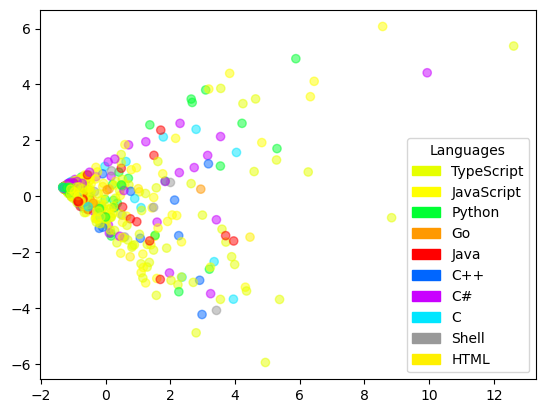

In [390]:

scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c = df["mainLanguage"].map(color_map), alpha=0.5)

legend_handles = [mpatches.Patch(color=color_map[language], label=language) for language in top_languages]
plt.legend(handles=legend_handles, title='Languages')
plt.show()

In [361]:
color_map

{'HTML': (0.267004, 0.004874, 0.329415, 1.0),
 'TypeScript': (0.281412, 0.155834, 0.469201, 1.0),
 'C': (0.244972, 0.287675, 0.53726, 1.0),
 'Shell': (0.190631, 0.407061, 0.556089, 1.0),
 'Go': (0.147607, 0.511733, 0.557049, 1.0),
 'C#': (0.119699, 0.61849, 0.536347, 1.0),
 'C++': (0.20803, 0.718701, 0.472873, 1.0),
 'Python': (0.430983, 0.808473, 0.346476, 1.0),
 'JavaScript': (0.709898, 0.868751, 0.169257, 1.0),
 'Java': (0.993248, 0.906157, 0.143936, 1.0)}

In [364]:
# Closes the connection
dataBaseConnection.close() 